In [162]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_circles

import torch
from torch import nn

In [163]:
# pip install numpy, matplotlib, scikit-learn, torch, tqdm

In [164]:
# optionnal parameters
plt.style.use("dark_background")
plt.style.use({"axes.facecolor": "#252526", "figure.facecolor": "#252526"})

## 0. Prepare Data

size of X: (300, 2)
size of y: (300,)


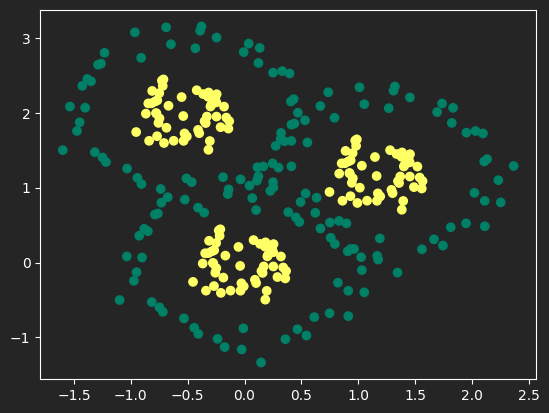

In [165]:
X_circle, y_circle = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = np.concatenate([X_circle, X_circle+1.2, X_circle+np.array([-0.5, +2])])
y = np.concatenate([y_circle, y_circle, y_circle])

print(f"size of X: {X.shape}")
print(f"size of y: {y.shape}")

plt.scatter(X[:, 0], X[:, 1], c=y.T, cmap="summer")
plt.show()

# data from numpy to torch
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
n_samples, n_features = X.shape

## 1. Define Model

In [166]:
class NeuralNetwork(nn.Module):
    """Neural Network Model for Machine Learnia exercise"""
    
    def __init__(self, in_features=2, nn_layers=[32, 16, 8], out_features=1):
        """Initialize the NN model

        Parameters
        ----------
        in_features : int, optional
            Input features, by default 2 for (x, y) coordinates
        nn_layers : list of int, optional
            Number of neurons in each layer, by default [32, 16, 8]
        out_features : int, optional
            Number of different outputs, by default 1
        """
        self.layers = nn_layers
        super().__init__() # instatiate our nn.Module
        
        # construct all layers
        self.input = nn.Linear(in_features, self.layers[0])
        for i in range(len(self.layers)-1):
            setattr(
                self, f"fc_{i+1}", nn.Linear(self.layers[i], self.layers[i+1])
            )
            # "fc" stands for "fully connected"
        self.output = nn.Linear(self.layers[-1], out_features)
    
    def forward(self, x) -> torch.Tensor:
        """Get model output using rectified linear unit function element-wise

        Parameters
        ----------
        x : torch.Tensor
            Tensor with "in_features" size

        Returns
        -------
        torch.Tensor
            Tensor with "out_features" size
        """
        x = nn.functional.relu(self.input(x))
        for i in range(len(self.layers) - 1):
            x = nn.functional.relu(getattr(self, f"fc_{i+1}")(x))
        x = self.output(x)
        
        return x

## 2. Train model

In [167]:
model = NeuralNetwork()

# loss function
criterion = nn.BCEWithLogitsLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# trainning (epoch = one run through all the training data in our network)
epochs = 1000
losses = []
for i in range(epochs):
    # go forward and get a prediction
    y_pred = model.forward(X)
    
    # measure the loss/error
    loss = criterion(y_pred.squeeze(), y)
    # (squeeze y_pred to correspond to the size of y)
    
    # keep track of our losses
    losses.append(loss.detach().numpy())
    
    # print everytime the loss is divided by 10
    if i == 0 or loss < loss_ref/10:
        loss_ref = loss
        print(f"Epoch: {i} and loss: {loss}")
    
    # do some back propagation to update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and loss: 0.6929159760475159
Epoch: 68 and loss: 0.06593875586986542
Epoch: 93 and loss: 0.0064504933543503284
Epoch: 226 and loss: 0.0006435770774260163
Epoch: 795 and loss: 6.426392792491242e-05


## 3. Print Results

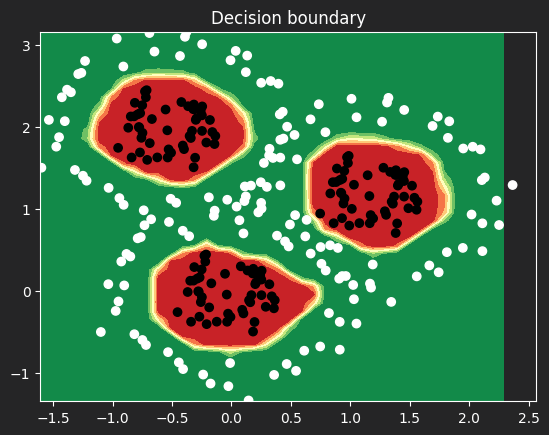

In [175]:
# avoid this operation to be tracked in torch
predicted = torch.sigmoid(model(X)).detach().numpy()

x1lim = np.add([X[:,0].min(), X[:,0].max()], np.array([-1, 1])/100)
x2lim = np.add([X[:,1].min(), X[:,1].max()], np.array([-1, 1])/100)
x1 = np.arange(x1lim[0], x1lim[1], 0.1)
x2 = np.arange(x2lim[0], x2lim[1], 0.1)

x1_grid, x2_grid = np.meshgrid(x1, x2)
x_grid_flatten = np.hstack((x1_grid.reshape(-1, 1), x2_grid.reshape(-1, 1)))

y_tensor = torch.sigmoid(model(torch.FloatTensor(x_grid_flatten)))
y_flatten = y_tensor.detach().numpy()

y_grid = y_flatten.reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, y_grid, cmap="RdYlGn_r")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="binary")
plt.title("Decision boundary")
plt.show()